# RMSE and MAE in one table for Report

In [1]:
# --- Load RMSE/MAE CSVs from FD001–FD004 artefact folders ---
# Run this from your project root (e.g., ".../Msc-Project-main").
# If your notebook is elsewhere, set ROOT to the absolute path shown below.

import re
from pathlib import Path
import pandas as pd

# If the notebook is in "Msc-Project-main", this is fine:
ROOT = Path.cwd()

# Otherwise, uncomment and paste your path:
# ROOT = Path(r"C:\Users\mg020649\Documents\15 - Coding\Msc-Project-main")

DATASET_DIR_PATTERN = re.compile(r"(FD\d{3})\s*data\s*&\s*artefacts", re.IGNORECASE)
CSV_NAME_HINTS = ("rmse", "mae", "metric", "result", "eval", "performance")

def find_fd_artifact_dirs(root: Path) -> dict:
    """Map 'FD001'..'FD004' -> Path('FD001 data & artefacts'), etc."""
    dirs = {}
    for p in root.iterdir():
        if p.is_dir():
            m = DATASET_DIR_PATTERN.search(p.name)
            if m:
                ds = m.group(1).upper()
                dirs[ds] = p
    return dict(sorted(dirs.items()))

def load_metrics_from_dir(ds_dir: Path) -> pd.DataFrame:
    """
    Load all CSVs in a dataset's artefacts folder that look like metrics files.
    Normalises common column names to: model, RMSE, MAE.
    """
    frames = []
    for csv_path in ds_dir.rglob("*.csv"):
        # Skip obviously unrelated CSVs by filename
        name_l = csv_path.name.lower()
        if not any(k in name_l for k in CSV_NAME_HINTS):
            continue
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            continue

        # Normalise column names
        rename_map = {}
        for c in df.columns:
            cl = c.strip().lower()
            if cl in {"model", "models", "name"}:
                rename_map[c] = "model"
            elif cl in {"rmse", "root_mse", "root mean square error"}:
                rename_map[c] = "RMSE"
            elif cl in {"mae", "mean_abs_error", "mean absolute error"}:
                rename_map[c] = "MAE"
        if rename_map:
            df = df.rename(columns=rename_map)

        df["source_file"] = csv_path.name
        df["source_path"] = str(csv_path)
        frames.append(df)

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def load_all_fd_metrics(root: Path = ROOT) -> dict:
    """Return dict like {'FD001': df, 'FD002': df, ...} of loaded metrics CSVs."""
    datasets = {}
    for ds, path in find_fd_artifact_dirs(root).items():
        df = load_metrics_from_dir(path)
        if not df.empty:
            df.insert(0, "Dataset", ds)
            datasets[ds] = df
            print(f"✓ {ds}: loaded {df.shape[0]} rows from {path}")
        else:
            print(f"⚠️ {ds}: no metrics-looking CSVs found under {path}")
    return datasets

# Load
all_metrics = load_all_fd_metrics()

# Example: peek at FD001 (if present)
if "FD002" in all_metrics:
    display(all_metrics["FD002"].head())

# (optional) Combine everything for later plotting
# combined_metrics = pd.concat(all_metrics.values(), ignore_index=True)
# display(combined_metrics.head())

✓ FD001: loaded 4 rows from C:\Users\mg020649\Documents\15 - Coding\Msc-Project-main\FD001 data & artefacts
✓ FD002: loaded 4 rows from C:\Users\mg020649\Documents\15 - Coding\Msc-Project-main\FD002 data & artefacts
✓ FD003: loaded 4 rows from C:\Users\mg020649\Documents\15 - Coding\Msc-Project-main\FD003 data & artefacts
✓ FD004: loaded 4 rows from C:\Users\mg020649\Documents\15 - Coding\Msc-Project-main\FD004 data & artefacts


,Dataset,model,RMSE,MAE,source_file,source_path
0,FD002,LSTM,21.90,16.77,fd002_metrics_seq30.csv,C:\Users\mg020649\Documents\15 - Coding\Msc-Pr...
1,FD002,CNN-LSTM,22.68,16.87,fd002_metrics_seq30.csv,C:\Users\mg020649\Documents\15 - Coding\Msc-Pr...
2,FD002,CNN,24.23,19.52,fd002_metrics_seq30.csv,C:\Users\mg020649\Documents\15 - Coding\Msc-Pr...
3,FD002,Base,24.29,19.70,fd002_metrics_seq30.csv,C:\Users\mg020649\Documents\15 - Coding\Msc-Pr...


In [2]:
# --- Combine all FD00x metrics into a clean, presentation-ready DataFrame ---
# Assumes you already ran the previous cell and have `all_metrics` (dict of DataFrames).
# If not, we try to load them again from disk.

import pandas as pd

def _ensure_loaded(all_metrics_dict=None):
    try:
        # if previous cell defined it
        if isinstance(all_metrics_dict, dict) and all_metrics_dict:
            return all_metrics_dict
    except NameError:
        pass
    # fallback: call the loader from the previous cell (must exist in the notebook)
    return load_all_fd_metrics(ROOT)

def build_presentation_metrics(all_metrics_dict=None, decimals=2) -> pd.DataFrame:
    all_metrics_dict = _ensure_loaded(all_metrics_dict)
    if not all_metrics_dict:
        raise RuntimeError("No metrics found. Run the loading cell first.")

    # Concatenate and keep only the essential columns
    df = pd.concat(all_metrics_dict.values(), ignore_index=True)

    # Standardise column names if needed
    rename_map = {c: c.strip() for c in df.columns}
    df = df.rename(columns=rename_map)
    # Common variants
    if "model" not in df.columns and "Model" in df.columns:
        df = df.rename(columns={"Model": "model"})
    if "RMSE" not in df.columns:
        # try lower-case
        if "rmse" in df.columns: df = df.rename(columns={"rmse": "RMSE"})
    if "MAE" not in df.columns:
        if "mae" in df.columns: df = df.rename(columns={"mae": "MAE"})
    if "Dataset" not in df.columns and "dataset" in df.columns:
        df = df.rename(columns={"dataset": "Dataset"})

    # Keep only the key columns and coerce numerics
    keep = [c for c in ["Dataset", "model", "RMSE", "MAE"] if c in df.columns]
    df = df[keep].copy()
    for c in ("RMSE", "MAE"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop duplicates and rows missing both metrics
    if "RMSE" in df.columns and "MAE" in df.columns:
        df = df.dropna(subset=["RMSE", "MAE"], how="all")
    df = df.drop_duplicates()

    # Round and sort for nicer presentation
    if "RMSE" in df.columns: df["RMSE"] = df["RMSE"].round(decimals)
    if "MAE"  in df.columns: df["MAE"]  = df["MAE"].round(decimals)

    # Order columns and rows
    ordered_cols = [c for c in ["Dataset", "model", "RMSE", "MAE"] if c in df.columns]
    df = df[ordered_cols].sort_values(by=["Dataset", "RMSE" if "RMSE" in df.columns else ordered_cols[-1]],
                                      ascending=[True, True]).reset_index(drop=True)

    # Tidy up model names (optional)
    if "model" in df.columns:
        df["model"] = df["model"].str.replace("_", "-").str.replace("cnn lstm", "CNN-LSTM", case=False)

    return df

presentation_df = build_presentation_metrics(all_metrics)
display(presentation_df)
# Optionally save for the report/appendix:
# presentation_df.to_csv("all_fd_metrics_clean.csv", index=False)

,Dataset,model,RMSE,MAE
0,FD001,LSTM,18.61,15.79
1,FD001,CNN-LSTM,19.13,15.28
2,FD001,CNN,19.50,15.29
3,FD001,Base,23.28,18.82
4,FD002,LSTM,21.90,16.77
5,FD002,CNN-LSTM,22.68,16.87
6,FD002,CNN,24.23,19.52
7,FD002,Base,24.29,19.70
8,FD003,LSTM,14.38,9.33
9,FD003,CNN,17.45,12.62


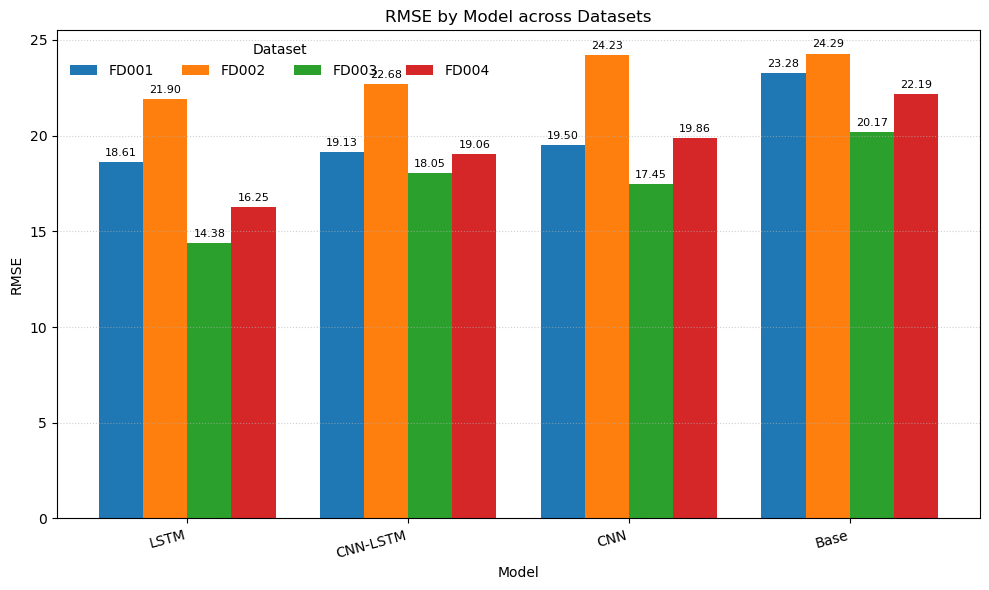

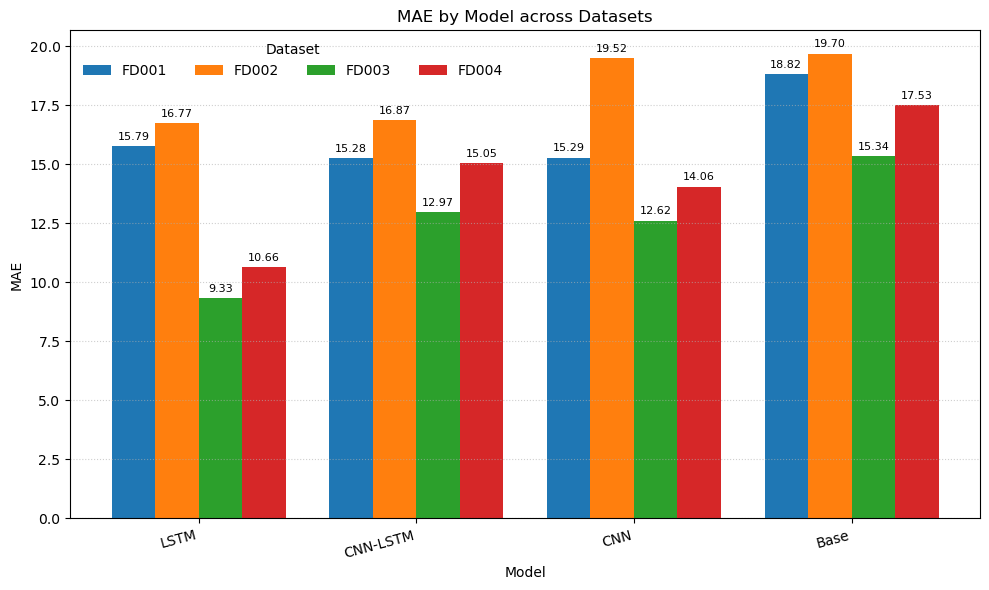

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Grouped bar chart: models on X, one colour per FD00X ----
def plot_metric_by_dataset(df: pd.DataFrame, metric: str = "RMSE",
                           palette: dict | None = None,
                           figsize=(10, 6), savepath: str | None = None):
    """
    df: tidy DataFrame with columns ['Dataset','model','RMSE','MAE'] (from presentation_df)
    metric: 'RMSE' or 'MAE'
    palette: optional dict mapping dataset -> color
    """
    assert metric in {"RMSE", "MAE"}, "metric must be 'RMSE' or 'MAE'"

    # Keep the necessary cols and pivot to wide for grouped bars
    work = df[["Dataset", "model", metric]].copy()
    # order models by their mean metric (lower is better)
    model_order = (work.groupby("model")[metric]
                   .mean().sort_values(ascending=True).index.tolist())
    datasets = sorted(work["Dataset"].unique())

    wide = (work.pivot_table(index="model", columns="Dataset", values=metric, aggfunc="mean")
            .reindex(model_order))

    # default palette if none provided
    if palette is None:
        # consistent mapping FD001..FD004
        base_colors = plt.cm.tab10.colors  # 10 distinct colors
        palette = {ds: base_colors[i % len(base_colors)] for i, ds in enumerate(datasets)}

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    n_models = len(wide.index)
    n_ds = len(datasets)
    x = np.arange(n_models)
    width = 0.8 / n_ds  # total bar group width ~0.8

    for i, ds in enumerate(datasets):
        values = wide[ds].values
        bar = ax.bar(x + i*width - (n_ds-1)*width/2, values, width,
                     label=ds, color=palette.get(ds))
        # add value labels
        for rect in bar:
            h = rect.get_height()
            ax.annotate(f"{h:.2f}", xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(wide.index, rotation=15, ha="right")
    ax.set_ylabel(metric)
    ax.set_xlabel("Model")
    ax.set_title(f"{metric} by Model across Datasets")
    ax.grid(axis="y", linestyle=":", alpha=0.6)
    ax.legend(title="Dataset", ncols=min(4, n_ds), frameon=False)
    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# ---- Usage (assumes `presentation_df` exists from previous cell) ----
plot_metric_by_dataset(presentation_df, metric="RMSE")
plot_metric_by_dataset(presentation_df, metric="MAE")

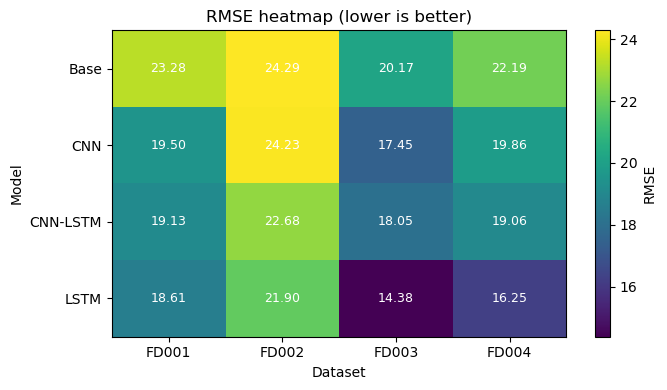

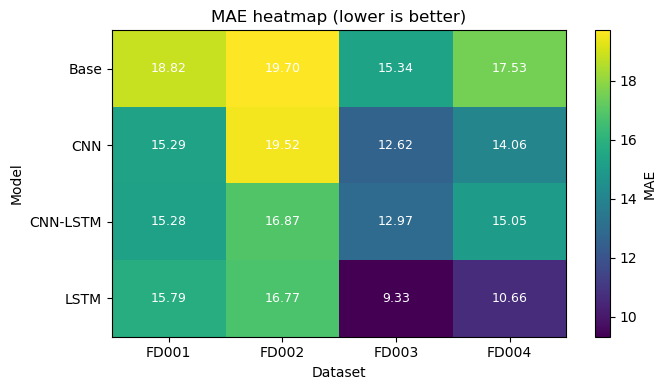

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def heatmap_metric(df, metric="RMSE", figsize=(7,4), savepath=None):
    pivot = df.pivot_table(index="model", columns="Dataset", values=metric, aggfunc="mean")
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_xticks(range(pivot.shape[1])); ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(pivot.shape[0])); ax.set_yticklabels(pivot.index)
    ax.set_title(f"{metric} heatmap (lower is better)")
    ax.set_xlabel("Dataset"); ax.set_ylabel("Model")
    # annotate cells
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i,j]:.2f}", ha="center", va="center", fontsize=9, color="white")
    fig.colorbar(im, ax=ax, label=metric)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Use it:
heatmap_metric(presentation_df, "RMSE")
heatmap_metric(presentation_df, "MAE")


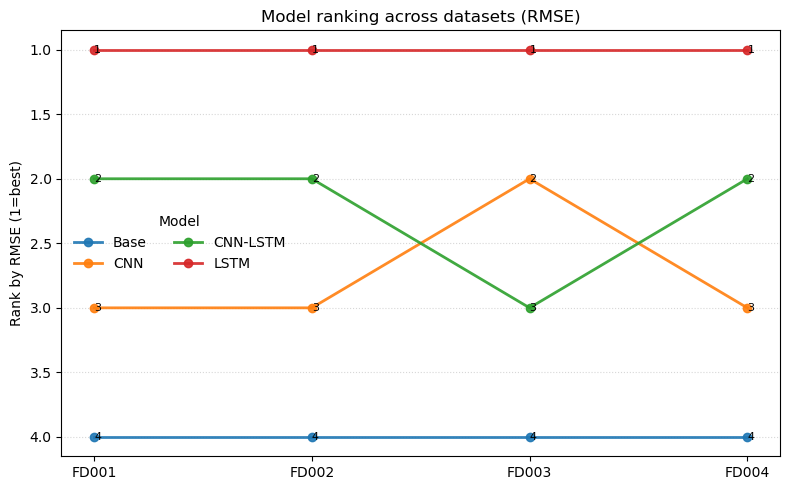

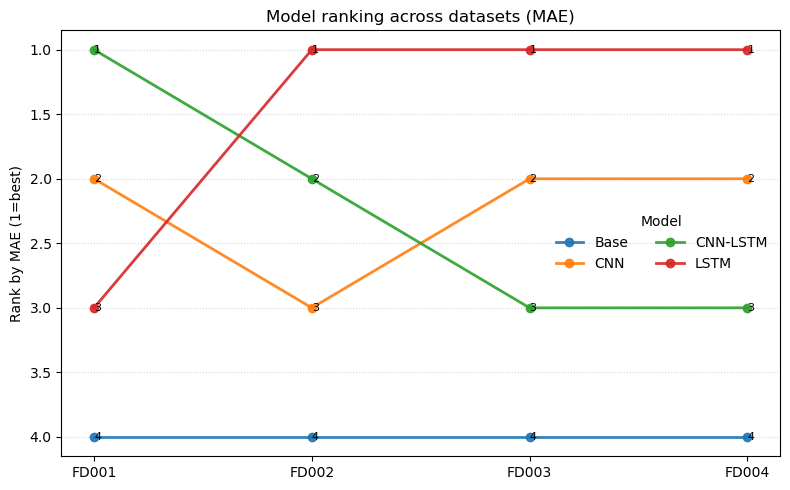

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def slopegraph_ranks(df, metric="RMSE", figsize=(8,5), savepath=None):
    # compute ranks per dataset (1 = best/lowest)
    ranks = (df.pivot_table(index="model", columns="Dataset", values=metric, aggfunc="mean")
               .rank(axis=0, method="min", ascending=True))
    datasets = ranks.columns.tolist()
    x = np.arange(len(datasets))

    fig, ax = plt.subplots(figsize=figsize)
    for model, row in ranks.iterrows():
        ax.plot(x, row.values, marker="o", linewidth=2, label=model, alpha=0.9)
        for xi, yi in zip(x, row.values):
            ax.text(xi, yi, f"{int(yi)}", va="center", ha="left", fontsize=8)

    ax.set_xticks(x); ax.set_xticklabels(datasets)
    ax.invert_yaxis()  # rank 1 at top
    ax.set_ylabel(f"Rank by {metric} (1=best)")
    ax.set_title(f"Model ranking across datasets ({metric})")
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    ax.legend(title="Model", frameon=False, ncols=2)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Use it:
slopegraph_ranks(presentation_df, "RMSE")
slopegraph_ranks(presentation_df, "MAE")


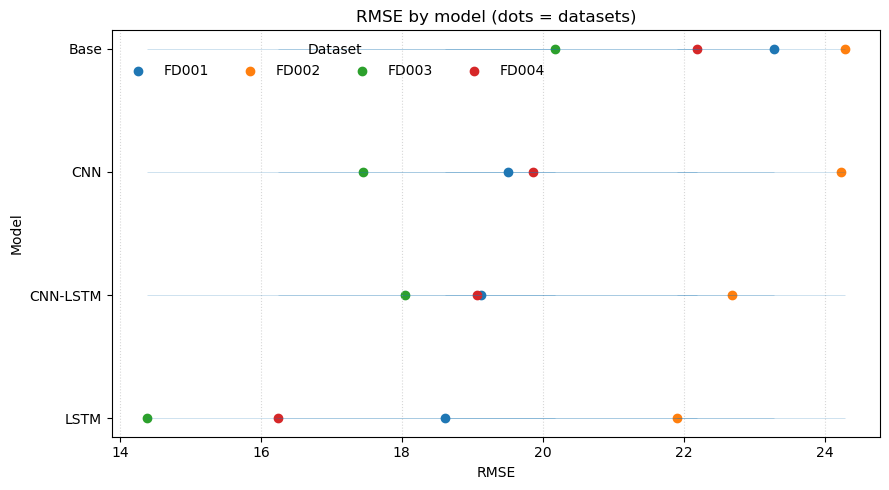

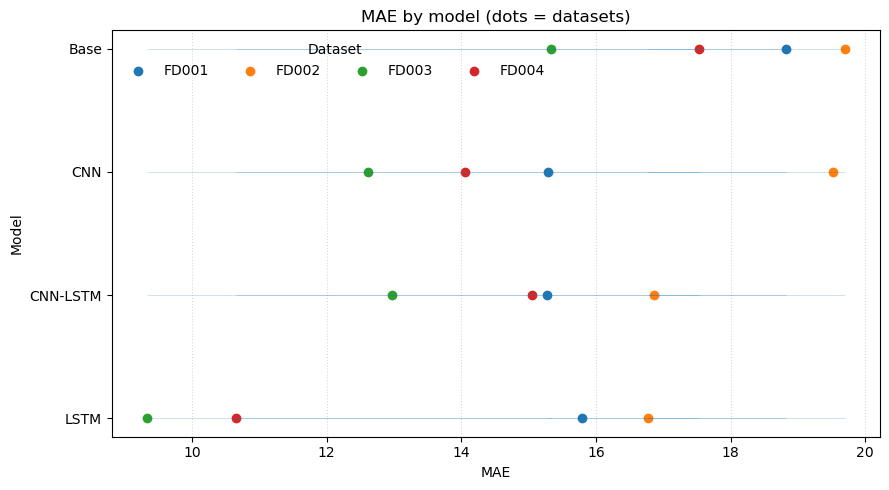

In [6]:
import matplotlib.pyplot as plt

def cleveland_dotplot(df, metric="RMSE", figsize=(9,5), savepath=None):
    work = df[["Dataset","model",metric]].copy()
    # order models by overall mean
    model_order = (work.groupby("model")[metric].mean()
                   .sort_values(ascending=True).index.tolist())
    datasets = sorted(work["Dataset"].unique())

    fig, ax = plt.subplots(figsize=figsize)
    y_positions = np.arange(len(model_order))
    for ds in datasets:
        vals = (work[work["Dataset"]==ds]
                  .set_index("model")
                  .reindex(model_order)[metric])
        ax.scatter(vals.values, y_positions, label=ds)
        # light stems for readability
        ax.hlines(y=y_positions, xmin=vals.min(), xmax=vals.max(), linewidth=0.5, alpha=0.3)

    ax.set_yticks(y_positions); ax.set_yticklabels(model_order)
    ax.set_xlabel(metric); ax.set_ylabel("Model")
    ax.set_title(f"{metric} by model (dots = datasets)")
    ax.grid(axis="x", linestyle=":", alpha=0.5)
    ax.legend(title="Dataset", frameon=False, ncols=min(4, len(datasets)))
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Use it:
cleveland_dotplot(presentation_df, "RMSE")
cleveland_dotplot(presentation_df, "MAE")


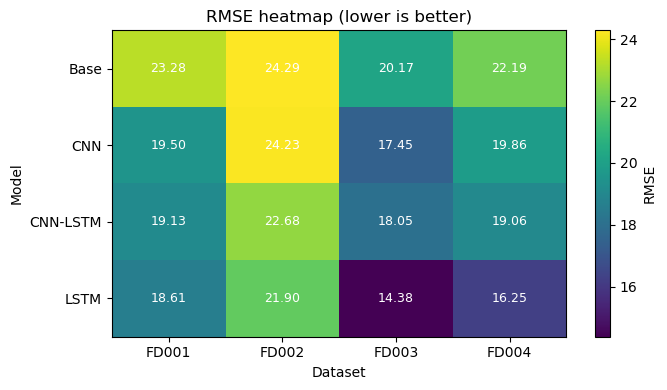

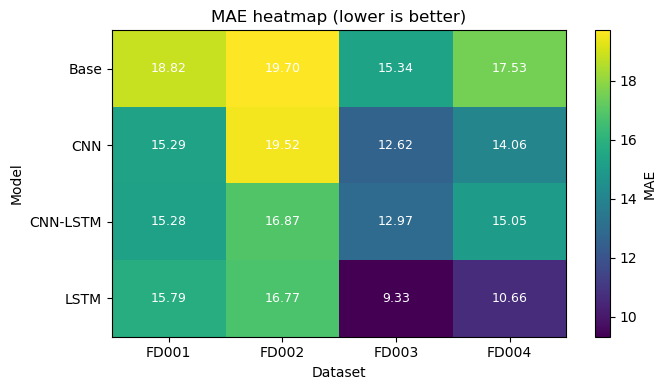

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def heatmap_metric(df, metric="RMSE", figsize=(7,4), savepath=None):
    pivot = df.pivot_table(index="model", columns="Dataset", values=metric, aggfunc="mean")
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_xticks(range(pivot.shape[1])); ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(pivot.shape[0])); ax.set_yticklabels(pivot.index)
    ax.set_title(f"{metric} heatmap (lower is better)")
    ax.set_xlabel("Dataset"); ax.set_ylabel("Model")
    # annotate cells
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i,j]:.2f}", ha="center", va="center", fontsize=9, color="white")
    fig.colorbar(im, ax=ax, label=metric)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Use it:
heatmap_metric(presentation_df, "RMSE")
heatmap_metric(presentation_df, "MAE")


In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1) Green → White → Red  (traffic-light with white mid)
def heatmap_metric_gwr(df, metric="RMSE", figsize=(7,4), savepath=None):
    pivot = df.pivot_table(index="model", columns="Dataset", values=metric, aggfunc="mean")
    cmap = LinearSegmentedColormap.from_list("gwr", ["#2ca25f", "#ffffff", "#de2d26"])
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(pivot.values, aspect="auto", cmap=cmap)
    ax.set_xticks(range(pivot.shape[1])); ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(pivot.shape[0])); ax.set_yticklabels(pivot.index)
    ax.set_title(f"{metric} heatmap (lower is better)")
    ax.set_xlabel("Dataset"); ax.set_ylabel("Model")
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i,j]:.2f}", ha="center", va="center", fontsize=9, color="black")
    fig.colorbar(im, ax=ax, label=metric)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# 2) Green → Yellow → Red (built-in, reversed so green=low, red=high)
def heatmap_metric_rdylgn(df, metric="RMSE", figsize=(7,4), savepath=None):
    pivot = df.pivot_table(index="model", columns="Dataset", values=metric, aggfunc="mean")
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(pivot.values, aspect="auto", cmap="RdYlGn_r")
    ax.set_xticks(range(pivot.shape[1])); ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(pivot.shape[0])); ax.set_yticklabels(pivot.index)
    ax.set_title(f"{metric} heatmap (lower is better)")
    ax.set_xlabel("Dataset"); ax.set_ylabel("Model")
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i,j]:.2f}", ha="center", va="center", fontsize=9, color="black")
    fig.colorbar(im, ax=ax, label=metric)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# 3) Green → Light Grey → Red (softer mid-tone)
def heatmap_metric_glgr(df, metric="RMSE", figsize=(7,4), savepath=None):
    pivot = df.pivot_table(index="model", columns="Dataset", values=metric, aggfunc="mean")
    cmap = LinearSegmentedColormap.from_list("glgr", ["#1b9e77", "#f0f0f0", "#d73027"])
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(pivot.values, aspect="auto", cmap=cmap)
    ax.set_xticks(range(pivot.shape[1])); ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(pivot.shape[0])); ax.set_yticklabels(pivot.index)
    ax.set_title(f"{metric} heatmap (lower is better)")
    ax.set_xlabel("Dataset"); ax.set_ylabel("Model")
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i,j]:.2f}", ha="center", va="center", fontsize=9, color="black")
    fig.colorbar(im, ax=ax, label=metric)
    fig.tight_layout()
    if savepath: fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# --- Usage examples ---


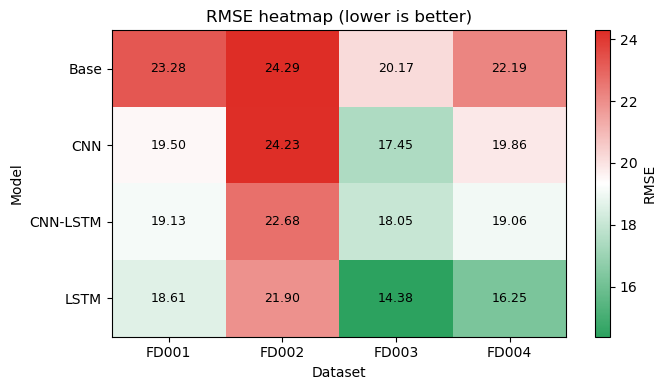

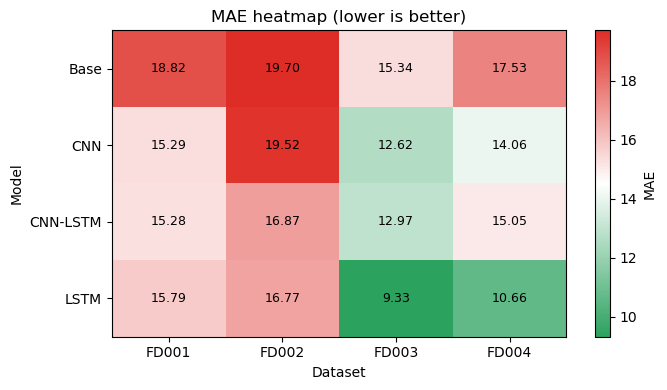

In [18]:
heatmap_metric_gwr(presentation_df, "RMSE")
heatmap_metric_gwr(presentation_df, "MAE")

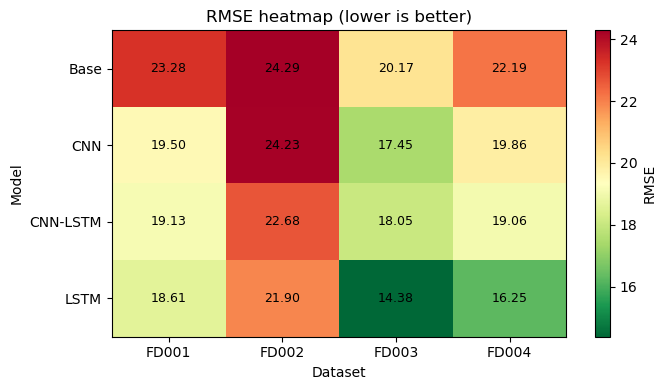

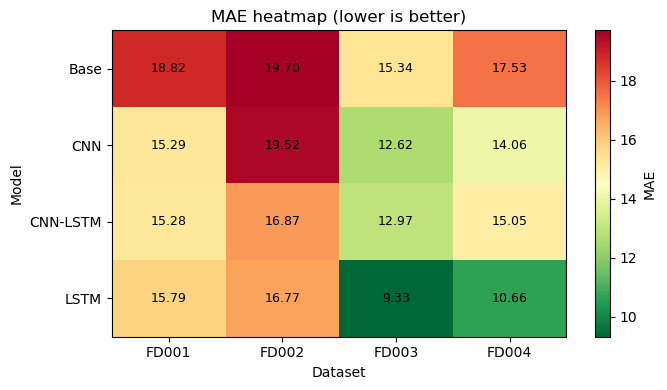

In [19]:
heatmap_metric_rdylgn(presentation_df, "RMSE")
heatmap_metric_rdylgn(presentation_df, "MAE")

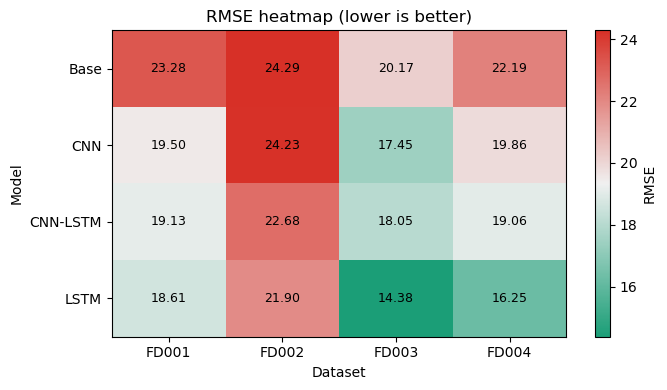

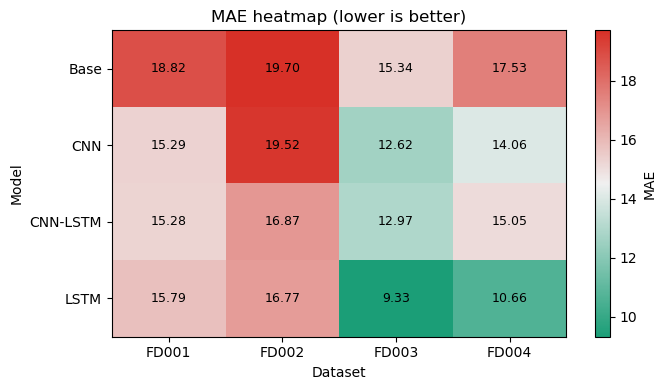

In [20]:
heatmap_metric_glgr(presentation_df, "RMSE")
heatmap_metric_glgr(presentation_df, "MAE")

In [23]:
import matplotlib.pyplot as plt

def plot_per_dataset_bars(df, metric="RMSE", figsize=(6,4), savepath=None):
    """
    Bar plots per dataset for a single metric, ordered lowest → highest.
    
    df: DataFrame with ['Dataset','model','RMSE','MAE']
    metric: 'RMSE' or 'MAE'
    """
    datasets = sorted(df["Dataset"].unique())
    
    for ds in datasets:
        subset = df[df["Dataset"]==ds].copy()
        subset = subset.sort_values(by=metric, ascending=True)

        fig, ax = plt.subplots(figsize=figsize)
        bars = ax.bar(subset["model"], subset[metric], color="skyblue", edgecolor="black")
        
        # annotate values
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f"{h:.2f}", 
                        xy=(bar.get_x() + bar.get_width()/2, h),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)
        
        ax.set_title(f"{metric} by Model — {ds}")
        ax.set_ylabel(metric)
        ax.set_xlabel("Model")
        ax.grid(axis="y", linestyle=":", alpha=0.6)
        plt.tight_layout()
        
        if savepath:
            fig.savefig(f"{savepath}_{ds}_{metric}.png", dpi=300, bbox_inches="tight")
        plt.show()

# Example usage:

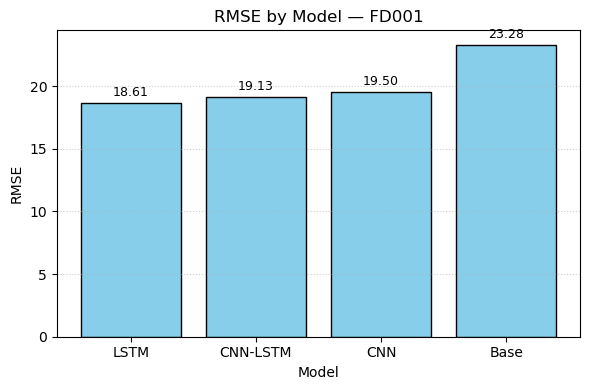

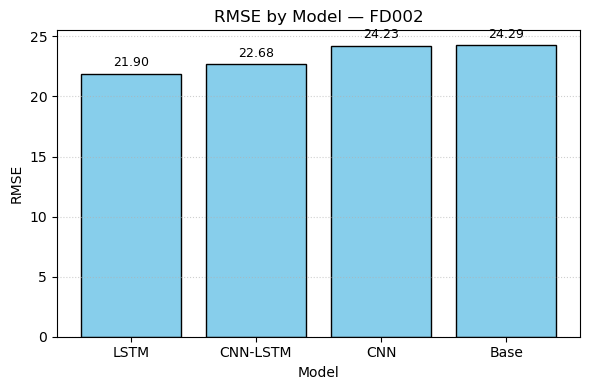

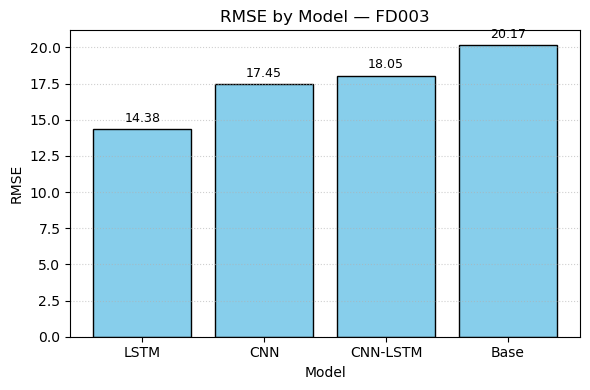

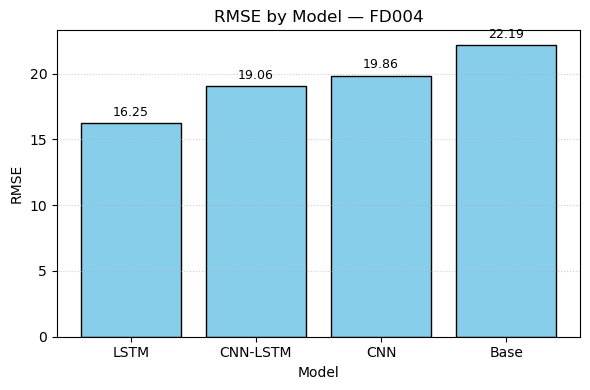

In [24]:
plot_per_dataset_bars(presentation_df, "RMSE")

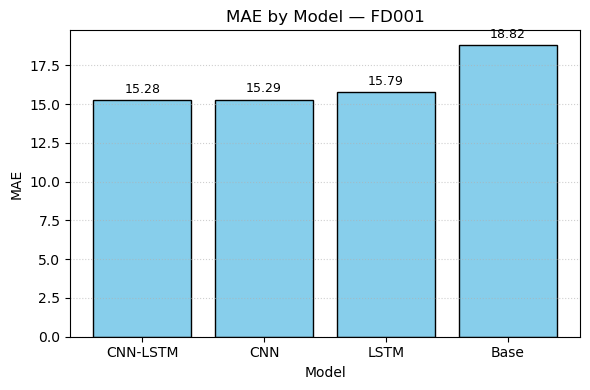

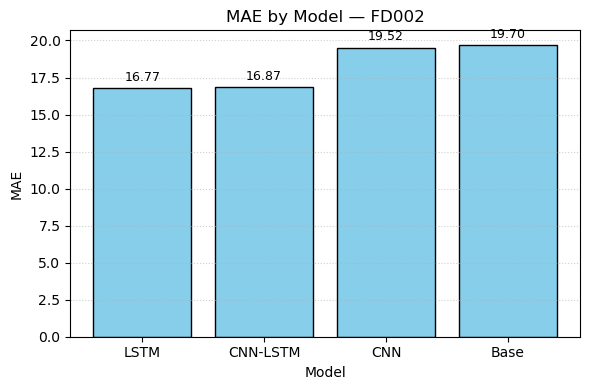

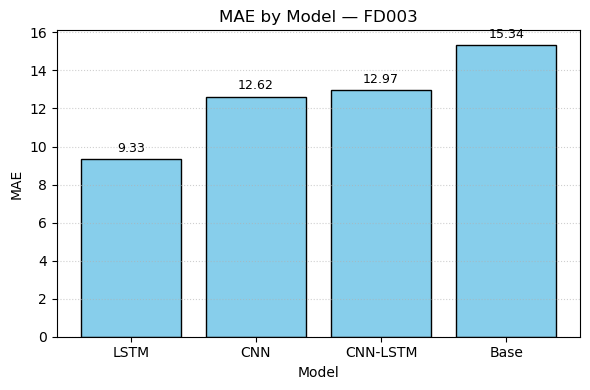

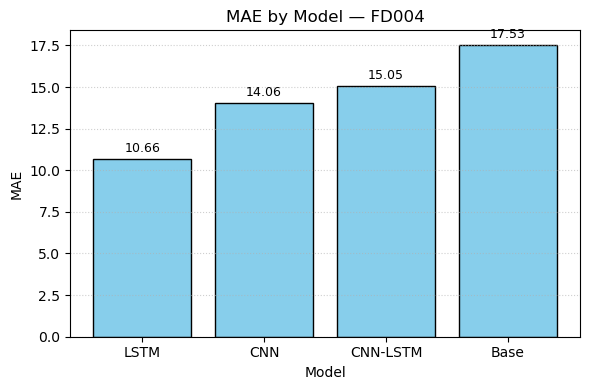

In [25]:
plot_per_dataset_bars(presentation_df, "MAE")

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_per_dataset_bars(df, metric="RMSE", figsize=(6,4), palette="skyblue", savepath=None):
    """
    Bar plots per dataset for a single metric, ordered lowest → highest.
    
    df: DataFrame with ['Dataset','model','RMSE','MAE']
    metric: 'RMSE' or 'MAE'
    palette: colour or seaborn palette name
    """
    datasets = sorted(df["Dataset"].unique())
    
    for ds in datasets:
        subset = df[df["Dataset"]==ds].copy()
        subset = subset.sort_values(by=metric, ascending=True)

        fig, ax = plt.subplots(figsize=figsize)
        
        # get colours
        if isinstance(palette, str):
            colors = sns.color_palette(palette, n_colors=len(subset))
        else:
            colors = palette
        
        bars = ax.bar(subset["model"], subset[metric], 
                      color=colors, edgecolor="black")
        
        # annotate values
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f"{h:.2f}", 
                        xy=(bar.get_x() + bar.get_width()/2, h),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)
        
        ax.set_title(f"{metric} by Model — {ds}")
        ax.set_ylabel(metric)
        ax.set_xlabel("Model")
        ax.grid(axis="y", linestyle=":", alpha=0.6)
        plt.tight_layout()
        
        if savepath:
            fig.savefig(f"{savepath}_{ds}_{metric}.png", dpi=300, bbox_inches="tight")
        plt.show()

# --- Test with three palettes ---

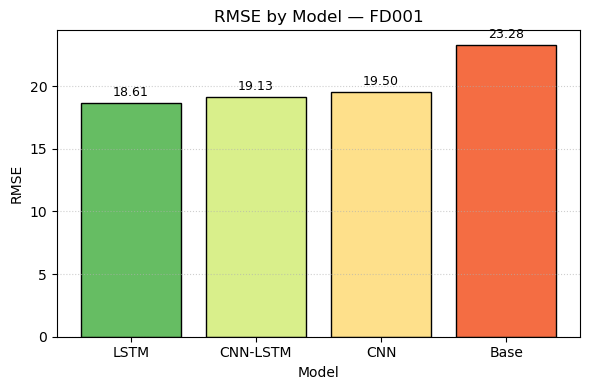

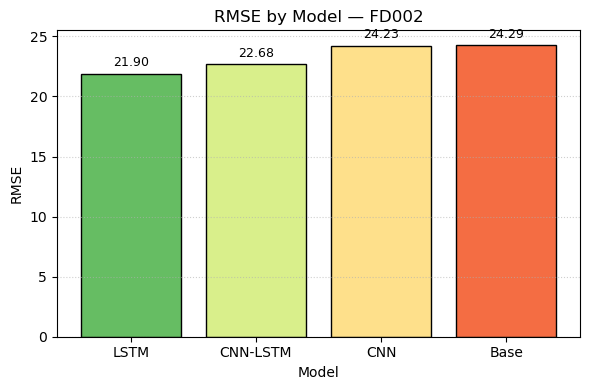

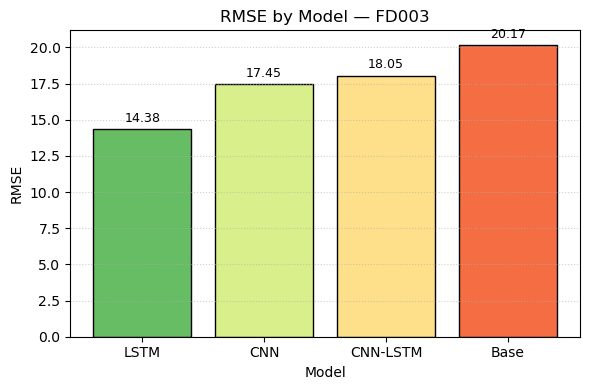

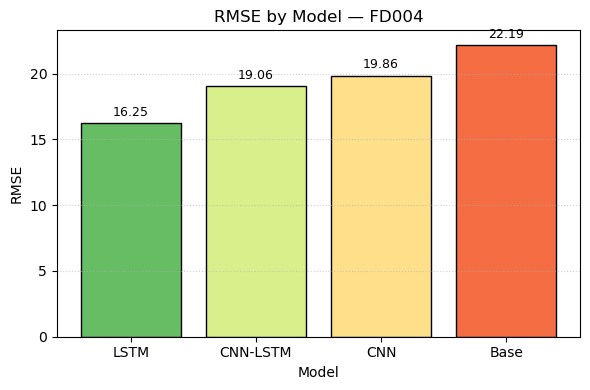

In [30]:
# 2) Green-to-red contrast
plot_per_dataset_bars(presentation_df, "RMSE", palette="RdYlGn_r")

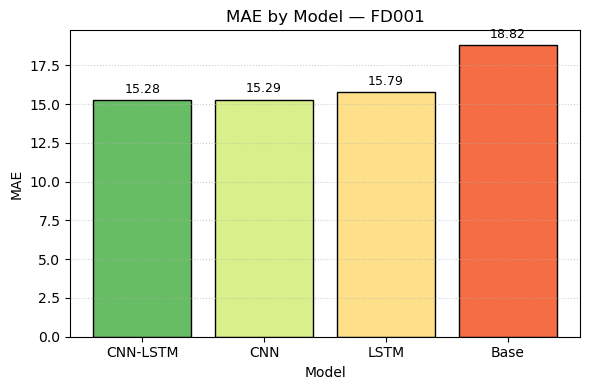

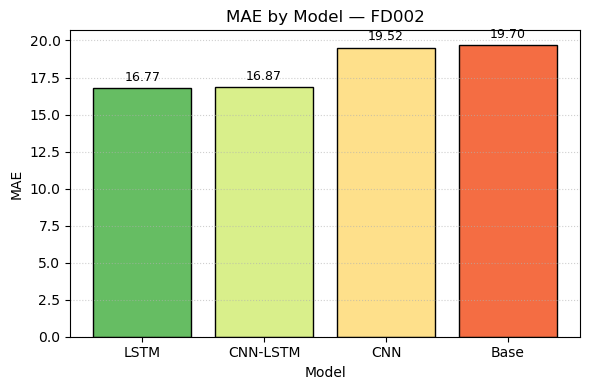

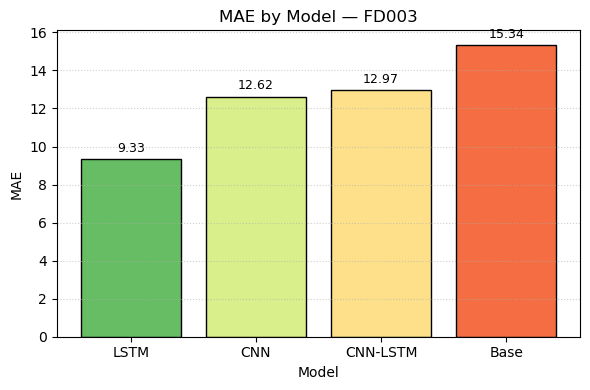

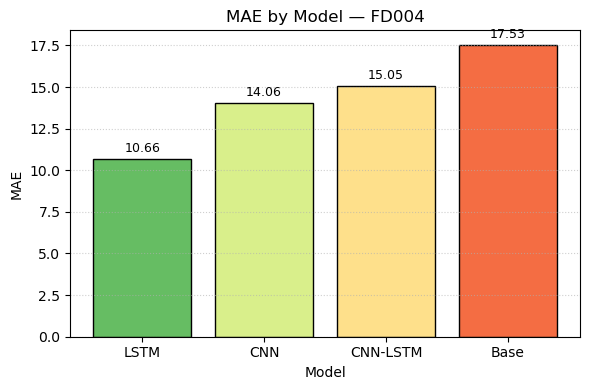

In [31]:
plot_per_dataset_bars(presentation_df, "MAE", palette="RdYlGn_r")